## !Please install torch, tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Loading

In [2]:
# load data. max is about 190, min is about 2.
train_data = np.load('..\data\FireEvac_train_set.npy', allow_pickle=True) # (3000, 2)
train_data = torch.Tensor(train_data)
test_data = np.load('..\data\FireEvac_test_set.npy', allow_pickle=True)   # (600, 2) 
test_data = torch.Tensor(test_data)

## Data Processing

In [3]:
# data preprocessing
max_, min_ = 200, 0
def data_preprocessing(data):
    return (data - min_) /  (max_ - min_) * 2 - 1
    
def data_preprocessing_inverse(data):
    return (max_ - min_) * (data + 1) / 2  + min_

In [4]:
train_data_scale = data_preprocessing(train_data)
test_data_scale = data_preprocessing(test_data)

## Model Definition

In [5]:
class Encoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(2, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)

        self.proj2mu = nn.Linear(hidden_dims, latent_dims)
        self.proj2sigma = nn.Linear(hidden_dims, latent_dims)

        self.N = torch.distributions.Normal(0, 1)

        self.kl = 0

    def forward(self, x):
        
        x = F.relu(self.linear1(x)) # (B, 64)
        x = F.relu(self.linear2(x)) # (B, 64)

        mu =  self.proj2mu(x) # (B, 2)
        sigma = torch.exp(self.proj2sigma(x)) # (B, 2)
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 / 2 + mu**2 / 2 - torch.log(sigma) - 1/2).mean()
        return z
    
class Decoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, 2)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = self.linear3(z)
        return z

    
class VAE(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(hidden_dims, latent_dims)
        self.decoder = Decoder(hidden_dims, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        
        return x_hat

## Configure Parameters, and Train the model

In [7]:
hidden_dims, latent_dims = 512, 10
lr = 0.001
epochs = 1000
vae = VAE(hidden_dims, latent_dims)


ep = []
train_loss_list = []
test_loss_list = []
# train
opt = torch.optim.Adam(vae.parameters(), lr)
for epoch in tqdm(range(epochs)):
    # for i, (x, y) in enumerate(tqdm(data, desc='training')):
    opt.zero_grad()
    x_hat = vae(train_data_scale)
    train_loss = ((train_data_scale - x_hat)**2).mean() + vae.encoder.kl
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        x_hat_test = vae(test_data_scale)
        test_loss = ((test_data_scale - x_hat_test)**2).mean() + vae.encoder.kl

    ep.append(epoch + 1) 
    train_loss_list.append(train_loss.item())
    test_loss_list.append(test_loss.item())
    


100%|██████████| 1000/1000 [02:01<00:00,  8.21it/s]


## Plot the Loss Curve

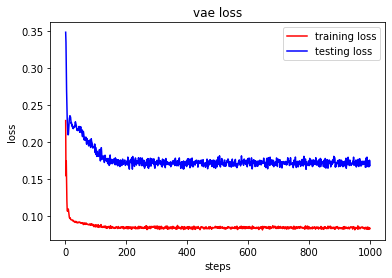

In [11]:
plt.title("vae loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.plot(ep, train_loss_list, 'red', label='training loss')
plt.plot(ep, test_loss_list, 'blue', label='testing loss')
plt.legend(loc="upper right")
plt.show()

## Generate New Data, Given $P_{\theta}(X|z)$, where $z \sim N(0,1)$

In [12]:
latent_vec = torch.randn(3000, latent_dims) 
result = vae.decoder(latent_vec)
result =  result.detach().numpy()

## Plot Data Distributions in 2-D Space for Train-Data, Test-Data, Generated-Data.

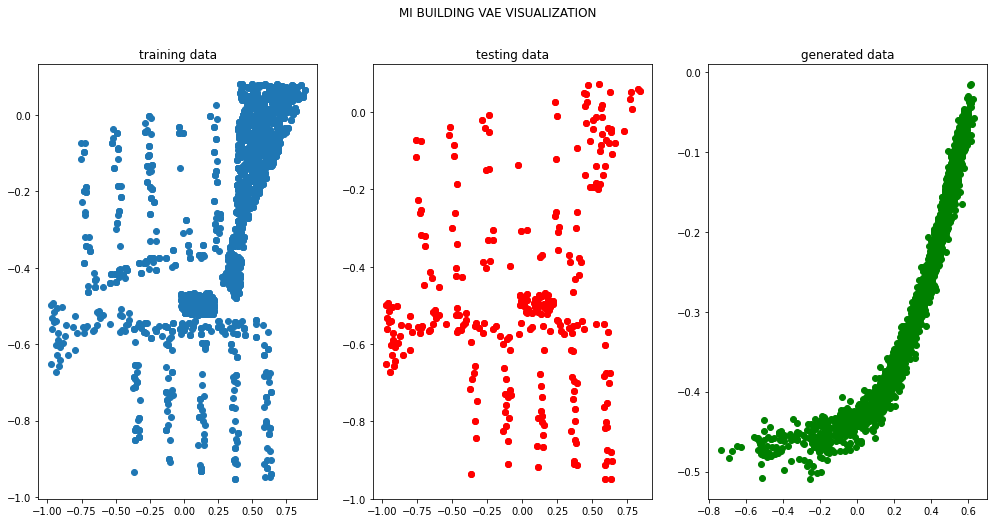

In [17]:
fig, ax = plt.subplots(1,3, figsize=(17,8))
fig.suptitle("MI BUILDING VAE VISUALIZATION")
ax[0].scatter(train_data_scale[:,0], train_data_scale[:,1])
ax[0].set_title("training data")
ax[1].scatter(test_data_scale[:,0], test_data_scale[:,1], c='red')
ax[1].set_title("testing data")
ax[2].scatter(result[:,0], result[:,1], c='green')
ax[2].set_title("generated data")
plt.show()